# TASK

### Deadline: 24 martie ora 23:59.
### Formular pentru trimiterea temei: https://forms.gle/LKCMJmyhS8Z8m7Rc9

1. Porniti de la un dataset artificial generat cu ajutorul metodei [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) din sklearn (minim 10000 de exemple, cu cel putin 100 de feature-uri relevante, grupate in cel putin 3 clase) sau puteti folosi un toy-dataset de [aici](https://scikit-learn.org/stable/datasets/toy_dataset.html).

2. Definiti un model cu cel putin 3 layere lineare, dintre care ultimul are dimensiunea outputului egala cu numarul de clase. Aplicati dupa fiecare layer linear (cu exceptia ultimului) o functie de activare aleasa de voi.

3. Impartiti datasetul in 80% train, 10% validare si 10% test. Creati cele trei dataloadere corespunzatoare fiecarui split.

4. Definiti functia de loss (cross-entropy) si un optimizer (SGD, Adam, etc.).

5. Antrenati modelul pentru mai multe epoci pe datele de train. La finalul fiecarei epoci evaluati performanta modelului pe datele de validare. Monitorizati la fiecare epoca eroarea medie si acuratetea pentru predictiile facute pe datele de train si separat pe datele de validare, pentru ca in cazul in care observati situatia de *overfit* sa puteti opri antrenarea.

6. Salvati modelul cu cea mai buna eroare de validare, calculata la finalul epocii respective.

7. Plotati pe acelasi grafic evolutia erorii de train si a erorii de validare la finalul fiecarei epoci. Plotati in alt grafic evolutia acuratetii pe datele de train si pe cele de validare.

8. Evaluati modelul (eroare, acuratete, macro-f1, etc.) pe datele de test.

9. Incercati sa adaugati dupa fiecare layer din model (cu exceptia ultimului) dropout cu un $p$ ales de voi. Analizati daca performanta unui model antrenat astfel este mai buna.

In [26]:
from sys import platform, path

if platform == "linux" or platform == "linux2":
    path.append('/home/dariusbuhai/python/lib/python3.9/site-packages')
import torch
import numpy as np

In [27]:
from sklearn.datasets import make_classification, load_breast_cancer

data = load_breast_cancer()
print(data.target_names)
X, y = data.data.astype(np.float32), data.target.astype(np.float32)
print(X.shape, y.shape)

['malignant' 'benign']
(569, 30) (569,)


In [58]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    # urmatoarele doua metode trebuie implementate
    def __getitem__(self, k):
        """Returneaza al k-lea exemplu din dataset"""
        return (
            self.data["vectors"][k],
            self.data["labels"][k]
        )

    def __len__(self):
        """Returneaza dimensiunea datasetului"""
        return len(self.data["labels"])

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [60]:
from torch.utils import data

dataset_train = MyDataset({"vectors": X_train, "labels": y_train})
dataloader_train = data.DataLoader(dataset_train, batch_size=4, shuffle=True)
dataset_test = MyDataset({"vectors": X_test, "labels": y_test})
dataloader_test = data.DataLoader(dataset_test, batch_size=4, shuffle=True)
dataset_val = MyDataset({"vectors": X_val, "labels": y_val})
dataloader_val = data.DataLoader(dataset_val, batch_size=4, shuffle=True)

In [174]:
from torch.nn import *


class Model(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        self.model = torch.nn.Sequential(
            Linear(X.shape[1], 60),
            Dropout(p=p),
            ReLU(),
            Linear(60, 30),
            Dropout(p=p),
            ReLU(),
            Linear(30, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [175]:
model = Model(p=0.2)
# Load best model
try:
    model.load_state_dict(torch.load("data/best_model.pt"))
except Exception:
    print("No best model defined")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = CrossEntropyLoss()
best_mean_loss = 100

No best model defined


In [176]:
import sklearn.metrics as metrics

def train_model(dataloader):
    model.train()
    for (vectors, labels) in dataloader:
        optimizer.zero_grad()
        output = model(vectors)
        loss = loss_fn(output, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()


def eval_model(dataloader, mean_losses=None, accuracies=None, save=True, show_f1=False):
    global best_mean_loss
    model.eval()
    true_labels, predicted_labels, mean_loss = [], [], 0
    with torch.no_grad():
        for (vectors, labels) in dataloader:
            output = model(vectors)
            loss = loss_fn(output, labels.type(torch.LongTensor))
            mean_loss += loss.item()
            true_labels.extend(labels.tolist())
            predicted_labels.extend(output.max(1)[1].tolist())
    mean_loss /= len(dataloader_val)
    accuracy = metrics.accuracy_score(true_labels, predicted_labels)
    f1_score = metrics.f1_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)
    print("Mean loss:", mean_loss)
    if show_f1:
        print("Macro f1:", f1_score)
    if mean_losses is not None and accuracies is not None:
        mean_losses.append(mean_loss)
        accuracies.append(accuracy)
    if mean_loss < best_mean_loss and save:
        torch.save(model.state_dict(), "data/best_model.pt")
        best_mean_loss = mean_loss

In [177]:
epochs = 100
train_mean_losses, val_mean_losses = [], []
train_accuracies, val_accuracies = [], []

for i in range(epochs):
    print(f"Epoch {i+1}\n")
    train_model(dataloader_train)
    print("Train: ")
    eval_model(dataloader_train, train_mean_losses, train_accuracies)
    print("Validation: ")
    eval_model(dataloader_val, val_mean_losses, val_accuracies)
    print()

Epoch 1

Train: 
Accuracy: 0.9347826086956522
Mean loss: 1.6616859031066549
Validation: 
Accuracy: 0.9423076923076923
Mean loss: 0.1805364308753409

Epoch 2

Train: 
Accuracy: 0.9369565217391305
Mean loss: 1.2546769524790131
Validation: 
Accuracy: 0.9230769230769231
Mean loss: 0.11990478692146447

Epoch 3

Train: 
Accuracy: 0.941304347826087
Mean loss: 1.248103781894315
Validation: 
Accuracy: 0.9423076923076923
Mean loss: 0.11914105827991779

Epoch 4

Train: 
Accuracy: 0.9369565217391305
Mean loss: 1.2721610602725728
Validation: 
Accuracy: 0.9807692307692307
Mean loss: 0.1016460508108139

Epoch 5

Train: 
Accuracy: 0.9369565217391305
Mean loss: 1.39945503457924
Validation: 
Accuracy: 0.9615384615384616
Mean loss: 0.10857343033421785

Epoch 6

Train: 
Accuracy: 0.941304347826087
Mean loss: 1.0734003709221724
Validation: 
Accuracy: 0.9423076923076923
Mean loss: 0.09088142754402585

Epoch 7

Train: 
Accuracy: 0.9543478260869566
Mean loss: 1.053355269120612
Validation: 
Accuracy: 0.9423076

In [178]:
import matplotlib.pyplot as plt
import numpy as np
def plot_metrics(values_x, values_y, name):
    plt.plot(np.array(range(1, len(values_x) + 1)), np.array(values_x))
    plt.plot(np.array(range(1, len(values_x) + 1)), np.array(values_y))
    plt.xlabel(name)
    plt.ylabel("Epochs")
    plt.show()

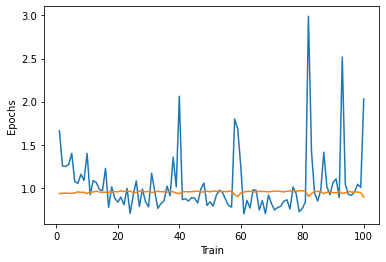

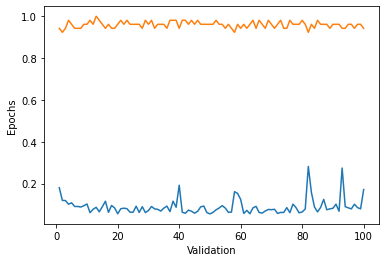

In [179]:
plot_metrics(train_mean_losses, train_accuracies, "Train")
plot_metrics(val_mean_losses, val_accuracies, "Validation")

In [180]:
model.load_state_dict(torch.load("data/best_model.pt"))
print("Evaluate test data:")
eval_model(dataloader_test, save=False, show_f1=True)

Evaluate test data:
Accuracy: 0.9824561403508771
Mean loss: 0.14214520217277682
Macro f1: 0.9855072463768115
